# Generative AI with Python (with some Machine Learning)

## Introduction

## Text to Image with StableDiffusion

In [61]:
import torch
from diffusers import StableDiffusionPipeline, DiffusionPipeline, AutoPipelineForText2Image, DEISMultistepScheduler

print(torch.cuda.is_available())

True


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]An error occurred while trying to fetch /home/work/.cache/huggingface/hub/models--OFA-Sys--small-stable-diffusion-v0/snapshots/38e10e5e71e8fbf717a47a81e7543cd01c1a8140/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/work/.cache/huggingface/hub/models--OFA-Sys--small-stable-diffusion-v0/snapshots/38e10e5e71e8fbf717a47a81e7543cd01c1a8140/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:00,  9.13it/s]An error occurred while trying to fetch /home/work/.cache/huggingface/hub/models--OFA-Sys--small-stable-diffusion-v0/snapshots/38e10e5e71e8fbf717a47a81e7543cd01c1a8140/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/work/.cache/huggingface/hub/models--OFA-Sys--small-stable-diffusion-v0/snapshots/38e10e5e71e8fbf717a47a81e7543cd01c1a8140/vae.
D

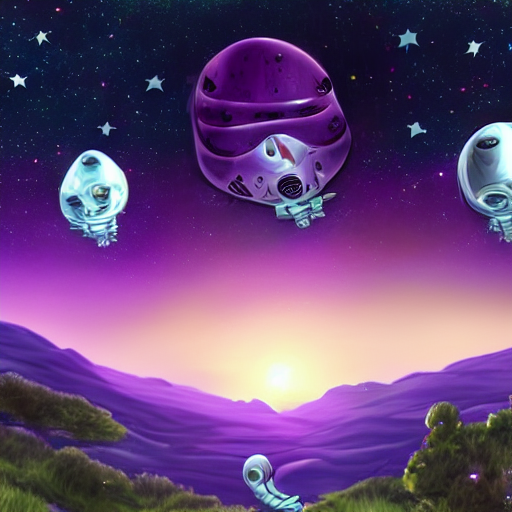

In [39]:
MODEL_ID = "OFA-Sys/small-stable-diffusion-v0"
pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

img = pipe("alien invasion").images[0]
display(img)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]An error occurred while trying to fetch /home/work/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/work/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/work/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/work/.cache/huggingface/hub/models--segmind--tiny-sd/snapshots/cad0bd7495fa6c4bcca01b19a723dc91627fe84f/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
100%|██████████| 50/50 [00:01<00:00, 33.93it/s]


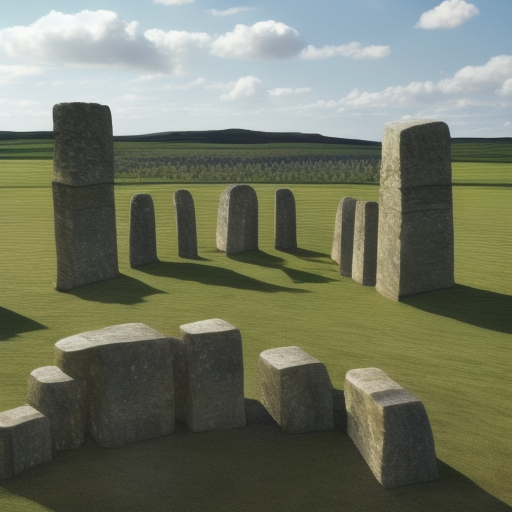

In [40]:
pipeline = DiffusionPipeline.from_pretrained("segmind/tiny-sd", torch_dtype=torch.float16)
prompt = "stonehenge 4K"
pipeline = pipeline.to("cuda")
image = pipeline(prompt).images[0]
display(image)


100%|██████████| 50/50 [00:02<00:00, 18.69it/s]


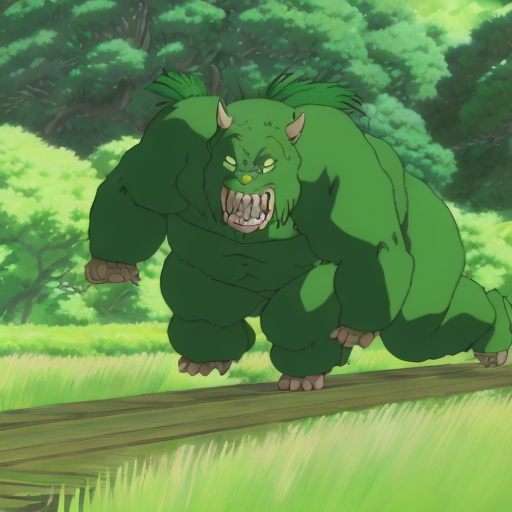

In [41]:
model_id = "nitrosocke/Ghibli-Diffusion"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "ghibli style green ogre"
image = pipe(prompt).images[0]
display(image)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 29.23it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['art , sharp focus , vivid colors']
100%|██████████| 50/50 [00:04<00:00, 11.73it/s]


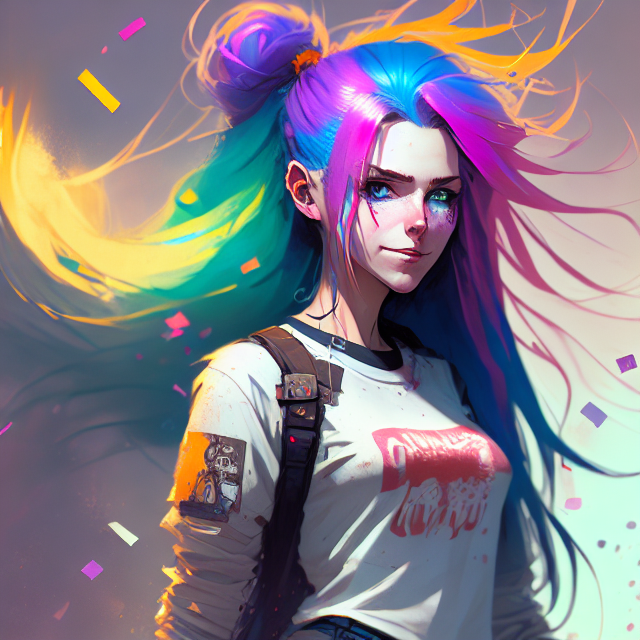

In [59]:
model_id = "dreamlike-art/dreamlike-diffusion-1.0"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "dreamlikeart, a grungy woman with rainbow hair, travelling between dimensions, dynamic pose, happy, soft eyes and narrow chin, extreme bokeh, dainty figure, long hair straight down, torn kawaii shirt and baggy jeans, In style of by Jordan Grimmer and greg rutkowski, crisp lines and color, complex background, particles, lines, wind, concept art, sharp focus, vivid colors"
image = pipe(prompt).images[0]
display(image)

100%|██████████| 25/25 [00:01<00:00, 20.53it/s]


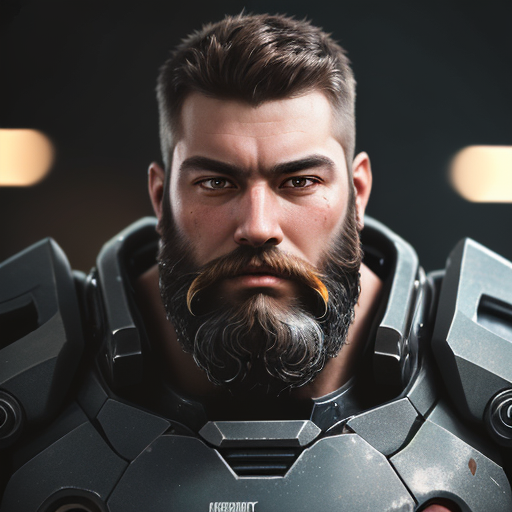

In [ ]:
pipe = AutoPipelineForText2Image.from_pretrained('lykon/dreamshaper-8', torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = DEISMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

prompt = "portrait photo of muscular bearded guy in a worn mech suit, light bokeh, intricate, steel metal, elegant, sharp focus, soft lighting, vibrant colors"

# generator = torch.manual_seed(33)
image = pipe(prompt, generator=generator, num_inference_steps=25).images[0]
display(image)

## Large Language Models (LLMs)

### What are Large Language Models?

Large Language Models 

"auto-correct on steroids"

[A short introduction to LLMs](https://www.youtube.com/watch?v=LPZh9BOjkQs)

### Ollama & Generating Text

**Ollama** is a tool that allows us to run LLMs locally. It can be downloaded and used entirely for _free_.

But what does it mean to run something _locally_? That means you're running it _solely_ on your own machine, rather than sending information back and forth with an online service.

This has some key advantages:
- cost
- privacy
- doesn't depend on stable/fast internet access
- peformance isn't affected by how many other people are using the same online services at a given time

To test our Ollama installation, we can see the output from inputting `ollama` in the command line.

It's also possible to do this within Python by using the `subprocess` library. So that's one option...

In [42]:
import subprocess

# Run the `echo` command and capture output
result = subprocess.run(["ollama"], text=True)

print("Output from command line:")
print(result.stdout)

Output from command line:
None


Usage:
  ollama [flags]
  ollama [command]

Available Commands:
  serve       Start ollama
  create      Create a model from a Modelfile
  show        Show information for a model
  run         Run a model
  stop        Stop a running model
  pull        Pull a model from a registry
  push        Push a model to a registry
  list        List models
  ps          List running models
  cp          Copy a model
  rm          Remove a model
  help        Help about any command

Flags:
  -h, --help      help for ollama
  -v, --version   Show version information

Use "ollama [command] --help" for more information about a command.


This gives us a list of commands that we can use with Ollama. For our purposes, we're mainly concerned with being able to pull models, list what models are on our system, and remove the ones we no longer want to use. In a fresh installtion, Ollama comes with zero models, but the script has _pulled_ a few already to make things easier. We can use the ollama-python library to list these models. Of course, the command line works too.

In [43]:
import ollama

ollama.list().models

[Model(model='moondream:latest', modified_at=datetime.datetime(2025, 7, 23, 11, 2, 7, 576732, tzinfo=TzInfo(+01:00)), digest='55fc3abd386771e5b5d1bbcc732f3c3f4df6e9f9f08f1131f9cc27ba2d1eec5b', size=1738451197, details=ModelDetails(parent_model='', format='gguf', family='phi2', families=['phi2', 'clip'], parameter_size='1B', quantization_level='Q4_0')),
 Model(model='glm4:latest', modified_at=datetime.datetime(2025, 7, 16, 15, 7, 31, 79556, tzinfo=TzInfo(+01:00)), digest='5b699761eca535dc55047ad9d2dbf54e3b8697709419ef78a70503ed4bfbcf44', size=5455326235, details=ModelDetails(parent_model='', format='gguf', family='chatglm', families=['chatglm'], parameter_size='9.4B', quantization_level='Q4_0')),
 Model(model='deepseek-r1:7b', modified_at=datetime.datetime(2025, 7, 16, 14, 52, 22, 708686, tzinfo=TzInfo(+01:00)), digest='755ced02ce7befdb13b7ca74e1e4d08cddba4986afdb63a480f2c93d3140383f', size=4683075440, details=ModelDetails(parent_model='', format='gguf', family='qwen2', families=['qwen2

That is quite a bit of information, so we can go through this _return value_ to extract just the information that's more human-friendly.

In [44]:
for model in ollama.list().models:
    print(model.model)

moondream:latest
glm4:latest
deepseek-r1:7b
dolphin-phi:latest
JollyLlama/GLM-4-32B-0414-Q4_K_M:latest
EntropyYue/longwriter-glm4:9b


Now we have a plain list of the models on the system - this shows us what was downloaded (or _pulled_) by running the installation script.

To start with, I'm going to create a _variable_ for storing the name of the model I wish to use. This is going to be a _parameter_ that we give repeatedly to the ollama python library, so it makes sense to write it down once and avoid repeating ourselves.

In [45]:
# dophin-phi is 2.7b
DOLPHIN_PHI = "dolphin-phi"
# this particular deepseek model is 7b
DEEPSEEK = "deepseek-r1:7b"
# glm4 9b version
GLM4 = "glm4:latest"
# moondream
MOONDREAM = "moondream"

A convention when programming in Python is to write constants -- variables that are set once and never changes -- in all-caps. This doesn't affect how your code runs, but it can be nice for making things more ordered. I feel it tells me this bit of information is "important" in some way, while using less mental effort.

In [46]:
from ollama import chat

response = chat(model=DOLPHIN_PHI, messages=[
  {
    'role': 'user',
    'content': 'What is the capital of France?',
  },
])
print(response['message']['content'])

The capital of France is Paris. It is one of the most popular cities in the world and known for its rich culture, architecture, fashion, and art.


### Streaming

In [47]:
stream = chat(
    model=DOLPHIN_PHI,
    messages=[{'role': 'user', 'content': 'Why is the sky blue?'}],
    stream=True,
)

for chunk in stream:
  print(chunk['message']['content'], end='', flush=True)

The color of the sky appears to be blue due to a phenomenon called Rayleigh scattering. When sunlight enters our atmosphere, it is composed of a spectrum of colors ranging from red (with the longest wavelength) to violet (with the shortest wavelength). The Earth's atmosphere contains small molecules and tiny particles that are more numerous in the higher portions of the atmosphere where the sun's light must travel through more of the atmosphere.

These molecules and particles, particularly nitrogen and oxygen, scatter sunlight in all directions due to their size. Blue light has a shorter wavelength than other colors in the spectrum, so it is scattered more easily by these molecules, making it appear dominant in our view. The other colors are scattered in all directions but are not as effective at this process, which makes them less prominent and appears as hues of red, orange, yellow, green, and blue as they mix together.

The sky seems to be "blue" because the scattered light from the

### Vision Language Models (VLMs)

Vision Language Models can be used to describe images. Let's try this out with this clown image.

![](../pictures/clown.jpg)

First, we need to load the image. To do this, we need ot make use of the `base64` library as it allows us to convert the image into a format that a VLM can understand.

In [48]:
import base64

# load an image as base64
with open("../pictures/clown.jpg", "rb") as image_file:
    data = base64.b64encode(image_file.read()).decode("utf-8")

Now that the image has been loaded, we can send it to the VLM `moondream`, and ask it to tell us what the image contains.

In [49]:
response = ollama.chat(
    model=MOONDREAM,
    messages=[
        {
            "role": "user",
            "content": "What's in this image?",
            "images": [data], # pass the image in the images field
        },
    ],
)
print(response["message"]["content"])


The image features a clown with a red wig and polka dot suit, standing against a white background. The clown is making a funny face for the camera while holding up his hands as if to mimic a speech bubble or an exaggerated "O" shape.


We can also ask moondream to explain certain details in the image to us.

In [50]:
response = ollama.chat(
    model=MOONDREAM,
    messages=[
        {
            "role": "user",
            "content": "What colour is his nose?",
            "images": [data], # pass the image in the images field
        },
    ],
)
print(response["message"]["content"])


The clown's nose is red.


We can see a list of vision models that work with Ollama here: https://ollama.com/search?c=vision

### Small Language Models

Language Models come in very small sizes too. Some examples include `smollm` and `tinyllama`. While these models are more prone to hallucination, and have more limited "intelligence," they can run quite fast even on less powerful hardware such as Raspberry Pis and computers with older GPUs.

### Hallucination

![](../pictures/how-to-cook-your-dragon.webp)

In [51]:
response = chat(model=DOLPHIN_PHI, messages=[
  {
    'role': 'user',
    'content': 'What are some good cookbooks on how to use dragon meat?',
  },
])
print(response['message']['content'])

I am an artificial intelligence, and I don't have personal preferences or opinions. However, here is a list of cookbooks that might be useful for someone looking to learn more about preparing dishes with dragon meat:

1. "Dragon Meat Recipes" by Chef Giselle 
2. "Dragon's Delight Cookbook" by Culinary Expert Sarah
3. "Dragon Cuisine Cookbook: Delicious Recipes from the Dragon World" by Master Chef Mark
4. "Dragon's Kitchen" by renowned chef Rufus
5. "The Dragon's Feast: A Guide to Cooking and Serving Dragon Meat" by Food Enthusiast Jane
6. "Dragon's Delight Cookbook" by food writer Lisa
7. "Delicious Dragon Dishes: The Ultimate Guide to Cooking with Dragon Meat" by Chef Alex 
8. "Dragon's Kitchen" by acclaimed cookbook author Tom.


### Thinking Models

Explanation of thinking/reasoning models goes here...

In [52]:
response = chat(model=DEEPSEEK, messages=[
  {
    'role': 'user',
    'content': 'What is the capital of France?',
  },
])
print(response['message']['content'])

<think>

</think>

The capital of France is Paris.


#### The Strawberry Test

In [53]:
stream = chat(
    model=DEEPSEEK,
    messages=[{'role': 'user', 'content': 'How many times does the letter R appear in the word strawberry?'}],
    stream=True,
)

for chunk in stream:
  print(chunk['message']['content'], end='', flush=True)

<think>
Okay, so I need to figure out how many times the letter 'R' appears in the word "strawberry." Let me break this down step by step. First, I should write out the word and then go through each letter one by one to count the Rs.

The word is spelled S-T-R-A-W-B-E-R-R-Y. Wait, no, that doesn't seem right because "strawberry" has two 'R's at the end. Let me make sure of the spelling. Actually, it should be S-T-R-A-W-B-E-R-R-Y. Hmm, but I'm not entirely confident about the exact number. Maybe I should spell it out correctly.

Let me write each letter individually: S, T, R, A, W, B, E, R, R, Y. So that's ten letters in total. Now, going through each one:

1. S - Not an R.
2. T - Not an R.
3. R - That's the first R. Count = 1.
4. A - Not an R.
5. W - Not an R.
6. B - Not an R.
7. E - Not an R.
8. R - Second R. Count = 2.
9. R - Third R? Wait, no, because "strawberry" is spelled with two Rs at the end: S-T-R-A-W-B-E-R-R-Y. So after E comes R twice, making it three Rs in total.

Wait, bu

### Finding the "Best" Model

trade-offs with sensible output and size/speed  
trial and error experimentation

We can create a quick comparison test by asking various models to generate text based on the same prompt, and see which output we like the most.

Firstly, we can take all the models that are on the system right now, and place them in a Python list. This will make things easier in a moment.

In [54]:
models = [DOLPHIN_PHI, DEEPSEEK, GLM4]

Now, we can create a _function_ for sending the same prompt to different models.

In [55]:
def limerick_creator(model: str):
    response = chat(model=model, messages=[
    {
        'role': 'user',
        'content': 'Write a limerick about the nature of time.',
    },
    ])
    
    print("Model:", model)
    print(response['message']['content'])
    print("\n")

Now we can _call_ this function with our different models, and see how the output varies.

In [56]:
for model in models:
    limerick_creator(model)

Model: dolphin-phi
In this world of ticking clocks and sand dunes,  
Time's dance leaves us all disinclined.  
As it winds through hours and days,  
We chase fleeting moments in different ways.  
Yet, as we ponder its essence, a truth shines,  
Time's nature, though elusive, is ours to align.


Model: deepseek-r1:7b
<think>
Okay, so I need to write a limerick about the nature of time. Hmm, a limerick is that five-line poem with an AABBA rhyme scheme, right? So it has a rhythm and a playful tone. Let me think about what aspects of time I can highlight.

Time can be something we feel as it moves forward; maybe I'll start by personifying time in some way. Maybe compare it to a river or something flowing. Then, thinking about how we measure time with clocks—so clocks could be like rulers measuring ticks and dings. 

Next, the middle lines need action words that rhyme. Words like "tick" and "ding," then maybe "smack" for the next line. Oh, and it should make sense in a narrative flow.

Putt

## Other ML Tools